In [1]:
from pickle import load

with open('result_summary.pkl', 'rb') as f:
    near_eq_result_summary = load(f)
    
def get_near_eq_curves_with_unc(scheme, marginal):
    r = near_eq_result_summary[scheme][marginal]
    return r['dts'], r['near_eq_estimates'], r['near_eq_uncertainty']

dts, mean, unc = get_near_eq_curves_with_unc('VRORV', 'configuration')

In [5]:
from tqdm import tqdm
import numpy as np
from benchmark.integrators import LangevinSplittingIntegrator
from benchmark.testsystems import water_cluster_rigid, NonequilibriumSimulator
from benchmark import simulation_parameters
from simtk import unit
temperature = simulation_parameters['temperature']

In [6]:
# let's see how this depends also on the collision_rate?

In [7]:
dts

array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ])

In [41]:
#dts = np.linspace(0.1, 8.0, 10) * unit.femtosecond

def estimate_acceptance_rate(scheme, dt, n_samples=10000, gamma=1.0/unit.picosecond):

    integrator = LangevinSplittingIntegrator(splitting=' '.join(scheme),
                                             temperature=temperature,
                                             timestep=dt * unit.femtosecond,
                                             collision_rate=gamma)
    noneq_sim = NonequilibriumSimulator(water_cluster_rigid, integrator)
    
    acceptance_ratios = np.zeros(n_samples)

    for i in range(n_samples):
        x0 = water_cluster_rigid.sample_x_from_equilibrium()
        v0 = water_cluster_rigid.sample_v_given_x(x0)
        acceptance_ratios[i] = min(1, np.exp(-noneq_sim.accumulate_shadow_work(x0, v0, 1)['W_shad'])) # already in units of kT
    return acceptance_ratios

In [42]:
def get_acceptance_rate_curve(scheme):
    """Get acceptance rate +/- stderr as a function of timestep."""
    acceptance_rates = np.zeros(len(dts))
    acceptance_rates_unc = np.zeros(len(dts))
    
    for i in tqdm(range(len(dts))):
        dt = dts[i]
        acceptance_ratios = estimate_acceptance_rate(scheme, dt)
        acceptance_rates[i] = np.mean(acceptance_ratios)
        acceptance_rates_unc[i] = 1.96 * np.std(acceptance_ratios) / np.sqrt(len(acceptance_ratios))
    return acceptance_rates, acceptance_rates_unc

schemes = ['OVRVO', 'ORVRO', 'VRORV', 'RVOVR']
acceptance_rate_curves = {}
acceptance_rate_unc_curves = {}
for scheme in schemes:
    mean, stderr = get_acceptance_rate_curve(scheme)
    acceptance_rate_curves[scheme] = mean
    acceptance_rate_unc_curves[scheme] = stderr

100%|██████████| 17/17 [04:51<00:00, 17.01s/it]


In [43]:
import seaborn.apionly as sns
schemes = sorted(['RVOVR', 'VRORV', 'OVRVO', 'ORVRO'])
colors = dict(zip(schemes, ['Blues', 'Greens', 'Oranges', 'Purples']))

colormaps = dict()

for scheme in schemes:
    colormap = sns.color_palette(colors[scheme], n_colors=len(dts))
    colormaps[scheme] = dict(zip(dts, colormap))
    
dt_ = sorted(dts)[int(len(dts) / 2)]
half_depth_colors = dict()
for scheme in schemes:
    half_depth_colors[scheme] = colormaps[scheme][dt_]

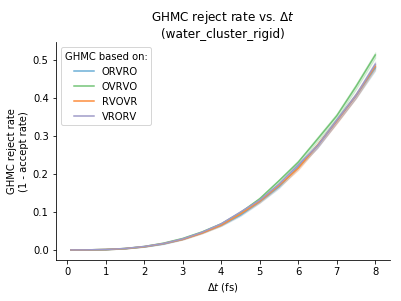

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
ax = plt.subplot(1,1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    
    mean, stderr = (1 - acceptance_rate_curves[scheme]), acceptance_rate_unc_curves[scheme]
    
    plt.plot(dts, mean, color=half_depth_colors[scheme], label=scheme)
    plt.fill_between(dts, mean - stderr, mean + stderr, color=half_depth_colors[scheme], alpha=0.25)
plt.legend(loc='best', title='GHMC based on:')
#plt.ylim(0.5,1)
plt.xlabel('$\Delta t$ (fs)')
plt.ylabel("GHMC reject rate\n(1 - accept rate)")
plt.title('GHMC reject rate vs. $\Delta t$' +  '\n(water_cluster_rigid)')
plt.savefig('water_cluster_reject_rate.jpg', dpi=300, bbox_inches='tight')

In [45]:
dts

array([ 0.1,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ])

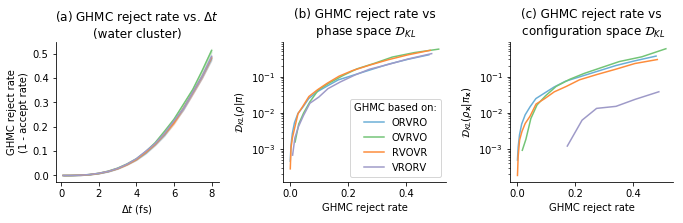

In [59]:
scale_factor = 3.2
n_cols = 3
n_rows = 1

plt.figure(figsize=(n_cols * scale_factor,n_rows * scale_factor))

ax = plt.subplot(n_rows,n_cols,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    
    mean, stderr = (1 - acceptance_rate_curves[scheme]), acceptance_rate_unc_curves[scheme]
    
    plt.plot(dts, mean, color=half_depth_colors[scheme], label=scheme)
    plt.fill_between(dts, mean - stderr, mean + stderr, color=half_depth_colors[scheme], alpha=0.25)
#plt.legend(loc='best', title='GHMC based on:')
#plt.ylim(0.5,1)
plt.xlabel('$\Delta t$ (fs)')
plt.ylabel("GHMC reject rate\n(1 - accept rate)")
plt.title('(a) GHMC reject rate vs. $\Delta t$' +  '\n(water cluster)')

ax = plt.subplot(n_rows,n_cols,2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    
    dts_, D_KL_phase_space = get_near_eq_curves_with_unc(scheme, 'full')[:2]
    
    mask = D_KL_phase_space > 1e-4
    
    acceptance_rate = np.array([acceptance_rate_curves[scheme][i] for i in range(len(dts)) if dts[i] in dts_])
    #D_KL_phase_space = np.array([entropy(rho.flatten(), exact_hist_xv.flatten()) for rho in phase_space_rhos[scheme]])
    #acceptance_rate = acceptance_rate_curves[scheme]
    plt.plot(1 - acceptance_rate[mask], D_KL_phase_space[mask], color=half_depth_colors[scheme], label=scheme)
    plt.xlabel('GHMC reject rate')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho \| \pi)$')
plt.title('(b) GHMC reject rate vs\n phase space ' +  r'$\mathcal{D}_{KL}$')
plt.legend(loc='best', title='GHMC based on:')

ax = plt.subplot(n_rows,n_cols,3, sharey=ax, sharex=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    
    dts_, D_KL_conf_space = get_near_eq_curves_with_unc(scheme, 'configuration')[:2]

    #D_KL_conf_space = np.array([entropy(rho_x, pi_x) for rho_x in conf_space_rhos[scheme]])
    acceptance_rate = np.array([acceptance_rate_curves[scheme][i] for i in range(len(dts)) if dts[i] in dts_])

    
    mask = D_KL_conf_space > 1e-4
    
    plt.plot(1 - acceptance_rate[mask],  D_KL_conf_space[mask], color=half_depth_colors[scheme], label=scheme)
    plt.xlabel('GHMC reject rate')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho_{\mathbf{x}} \| \pi_{\mathbf{x}})$')
plt.title('(c) GHMC reject rate vs\n configuration space ' +  r'$\mathcal{D}_{KL}$')
#plt.legend(loc='best', title='GHMC based on:')


plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()
plt.savefig('water_cluster_acceptance_rate_vs_D_KL.jpg', dpi=300, bbox_inches='tight')